## Synthesis of all the code to produce analysis

In [6]:
## Necessary functions and input
%matplotlib inline
# useful additional packages 

#import math tools
import numpy as np
import random as rand
# We import the tools to handle general Graphs
import networkx as nx
from scipy.optimize import fmin, minimize,differential_evolution,brute
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram
#IBMQ.save_account('b4c22f9da67ce0063a7cf1b2666f87fcb3641addb701a8cb1d9f9acd86a9ebfc3e988ab715fa2371432551b983934805a5dbe0c54b249d1f3047e00f304b8663')
#provider = IBMQ.load_account()
from qiskit.visualization import plot_histogram
import qiskit.providers.aer.noise as noise
π=np.pi

In [7]:
def cost_function_C(x,G): #Taken back from the textbook, needs to be adapted to the considered optimization problem
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        w      = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
        
    return C

def QAOA_circuit(γ,β,G):  # Returns an appropriate quantum circuit mapping p blocks (length of γ,β) 
                                #of evolution according to the cost Hamiltonian induced by graph G
    QAOA=QuantumCircuit(len(G.nodes()),len(G.nodes()))
    QAOA.h(range(len(G.nodes())))
    QAOA.barrier()
    
    for i in range(len(γ)): #exp(-i*γ*H_c) repeated with different angles γ for each block
        for edge in G.edges():
            k = edge[0]
            l = edge[1]
            QAOA.cu1(2*γ[i], k, l)
            QAOA.u1(-γ[i], k)
            QAOA.u1(-γ[i], l)
    
    # then apply the single qubit X - rotations with angle β to all qubits (exp(-i*β*H_b))
        QAOA.barrier()
        QAOA.rx(-2*β[i], range(len(G.nodes())))

    # Finally measure the result in the computational basis
    QAOA.barrier()
    QAOA.measure(range(len(G.nodes())),range(len(G.nodes())))
    
    return QAOA

def QAOA_noisy_local_model(γ,β,G,prob=[0.,0.,0.]):  # Returns an appropriate quantum circuit mapping p blocks (length of γ,β) 
    
    
    QReg=QuantumRegister(len(G.nodes()))
    CReg=ClassicalRegister(len(G.nodes()))
    QAOA=QuantumCircuit(QReg,CReg)
    QAOA.h(QReg)
    QAOA.barrier()
    
    for i in range(len(γ)): #exp(-i*γ*H_c) repeated with different angles γ for each block
        for edge in G.edges():
            k = int(edge[0])
            l = int(edge[1])
            
            QAOA.cp(2*γ[i], QReg[k], QReg[l])
            QAOA.p(-γ[i], QReg[k])
            QAOA.p(-γ[i], QReg[l])
            
            phase_flip(QAOA,QReg,prob[0])
            depolarizing_noise(QAOA,QReg,prob[1])
            bit_flip(QAOA,QReg,prob[2])
    
    # then apply the single qubit X - rotations with angle β to all qubits (exp(-i*β*H_b))
        QAOA.barrier()
        QAOA.rx(-2*β[i],QReg)

    # Finally measure the result in the computational basis
    QAOA.barrier()
    QAOA.measure(QReg,CReg)
    
    return QAOA

def phase_flip(Circuit,QReg,probability=0.05):  #Apply a Z gate with given probability
    #Last boolean indicates if one wants to add the channel
    n=Circuit.num_qubits
    for i in range(n):
        p=rand.uniform(0,1)
        if (p<probability):  
            Circuit.z(QReg[i])
def bit_flip(Circuit,QReg,probability=0.05): #Apply a X gate with given probability
    
    n=Circuit.num_qubits
    for i in range(n):
        p=rand.uniform(0,1)
        if (p<probability):
            Circuit.x(QReg[i])
def depolarizing_noise(Circuit,QReg,probability=0.05): #Apply X,Y,Z each with given probability/3

    n=Circuit.num_qubits
    for i in range(n):
        p=rand.uniform(0,1)
        if (p<probability):
            if (p<probability/3.):
                Circuit.x(QReg[i])
            elif((p<2*probability/3.)and(p>probability/3.)):
                Circuit.y(QReg[i])
            else:
                Circuit.z(QReg[i])
                 
        


In [8]:
def best_string(angles,G,prob=[0.,0.,0.],backend_1=Aer.get_backend("qasm_simulator"),shots_1=10000,noise=False):
    
    
    l=len(angles)
    γ=angles[0:l:2]
    β=angles[1:l:2]
    if(noise):
        simulate=execute(QAOA_noisy_local_model(γ,β,G,prob),backend=backend_1,shots=shots_1)
    else:
        simulate=execute(QAOA_circuit(γ,β,G),backend=backend_1,shots=shots_1)
    QAOA_results=simulate.result()
    counts=QAOA_results.get_counts()
    
    avr_C       = 0
    max_C       = [0,0]

    for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
        x         = [int(num) for num in list(sample)]
        tmp_eng   = cost_function_C(x,G)
        #print(sample,tmp_eng)
    
    # compute the expectation value and energy distribution
        avr_C     = avr_C    + counts[sample]*tmp_eng
        #print("bitstring :",sample,"prob: ",counts[sample]/shots_1, "associated cost:", tmp_eng)
        # save best bit string
        if( max_C[1] < tmp_eng):
            max_C[0] = sample
            max_C[1] = tmp_eng
    max_C.append(counts[max_C[0]]/shots_1)
    
    
                
    Mp_sampled   = avr_C/shots_1
    
    return Mp_sampled, max_C, counts

def computation(angles,G=None,backend_1=Aer.get_backend("qasm_simulator"),shots_1=10000,prob=[0.,0.,0.]): #New function similar to computation, but for the new graph
    if (G==None): # Define the Graph here if not possible to define it outside the function, this is the case for integrated Qiskit optimizers, such as SPSA which is the most suited here
        n     = 7
        V     = np.arange(0,n,1)
        E     =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0),(2,6,1.0),(5,3,1.0),(0,4,1.0),(5,6,1.0),(1,6,1.0)] 
        G     = nx.Graph()
        G.add_nodes_from(V)
        G.add_weighted_edges_from(E)
        
    l=len(angles)
    γ=angles[0:l:2]
    β=angles[1:l:2]
    simulate=execute(QAOA_noisy_local_model(γ,β,G,prob),backend=backend_1,shots=shots_1)
    QAOA_results=simulate.result()
    counts=QAOA_results.get_counts()
    
    avr_C       = 0

    for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
        x         = [int(num) for num in list(sample)]
        tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
        avr_C     = avr_C    + counts[sample]*tmp_eng
        
    
    
                
    Mp_sampled   = avr_C/shots_1
    
    return -Mp_sampled

In [9]:
def result_optimization(G,optimizer='COBYLA',p_min=1,p_max=5,prob=[0.,0.,0.],backend=Aer.get_backend("qasm_simulator")):
    p=[]
    exp=[]
    opti_angles=[]
    ratio=[]
    max_value=9.
    
    for j in range(p_min,p_max+1):
        if (j==1):
            print("Optimization for",j,"block")
        else:
            print("Optimization for",j,"blocks")
        angles=[]
        min_bound=[]
        max_bound=[]
        for i in range(j):
            a=rand.uniform(0,2*π)
            b=rand.uniform(0,π)
            angles.append(a)
            angles.append(b)
            min_bound.append(0.)
            min_bound.append(0.)
            max_bound.append(2*π)
            max_bound.append(π)
        
        
        p.append(j)
        boundaries=[]

        for i in range(2*j):
            boundaries.append((min_bound[i],max_bound[i]))
        
        if (optimizer=='brute'):
            opti_angles1,expminus=brute(func=computation,ranges=boundaries,args=(G,backend,10000,prob),Ns=10,finish=fmin)
            exp.append(-expminus)
            ratio.append(-expminus/9.0)
            opti_angles.append(opti_angles1)
        elif (optimizer=='differential_evolution'):
            Opti_Result=differential_evolution(computation,bounds=boundaries,args=(G,backend,10000,prob),tol=0.1)
            opti_angles.append(Opti_Result.x)
            exp.append(-Opti_Result.fun)
            ratio.append(-Opti_Result.fun/9.0)
        elif (optimizer=='SPSA'):
            op=SPSA(max_trials=1000*j)
            #op.wrap_function(computation,(G,backend,10000,prob))
            opti_angles1,expminus,nfv=op.optimize(len(angles),computation,variable_bounds=boundaries,initial_point=angles)
            exp.append(-expminus)
            ratio.append(-expminus/9.0)
            opti_angles.append(opti_angles1)
        else:
            Opti_Result=minimize(fun=computation,x0=angles,args=(G,backend,10000,prob),method= optimizer,
                        bounds=boundaries)
            opti_angles.append(Opti_Result.x)
            exp.append(-Opti_Result.fun)
            ratio.append(-Opti_Result.fun/9.0)
            
    print("Optimization done")
    return p,ratio,exp,opti_angles
    
    

## Definition of the graph

Depending on the optimizer used, it is possible to define the graph outside of the function result_optimization, but if optimizer is chosen among the one integrated in Qiskit Aqua (like SPSA), we have to define graph inside in order to pass the graph as an argument for computing the quantum circuit.

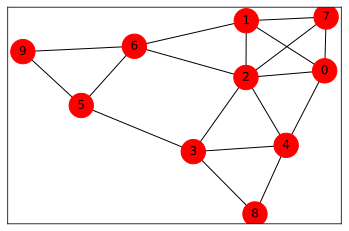

In [10]:
n     = 10
V     = np.arange(0,n,1)
E     =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0),(2,6,1.0),(5,3,1.0),(0,4,1.0),(5,6,1.0),(1,6,1.0),(3,8,1.0),(4,8,1.0),(5,9,1.0),(2,7,1.0),(6,9,1.0),(1,7,1.0),(0,7,1.0)] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)


# Simulator, COBYLA

In [ ]:
#p,ratio,exp,opti_angles=result_optimization(G,optimizer='SPSA',p_min=5,p_max=5)


probability=[]
ratio=[]
for i in range(0,21):
    probability.append(0.05*i)
    print("Going for p_error=",0.05*i)
    p,ratio1,exp,opti_angles=result_optimization(G,optimizer='SPSA',p_min=2,p_max=2,prob=[0.0,0.0,0.05*i],backend=Aer.get_backend('qasm_simulator'))
    ratio.append(ratio1)
    print(ratio1)
    
print(probability,ratio)



Going for p_error= 0.0
Optimization for 2 blocks


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/qiskit/aqua/components/optimizers/optimizer.py:49: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('aqua.components.optimizers',
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/qiskit/aqua/components/optimizers/spsa.py:93: DeprecationWarning: The max_trials parameter is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use maxiter instead.
  warnings.warn('The max_trials parameter is deprecated as of '
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/qiskit/aqua/components/optimizers/spsa.py:237: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was

Optimization done
[0.7205888888888888]
Going for p_error= 0.05
Optimization for 2 blocks


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/qiskit/aqua/components/optimizers/spsa.py:93: DeprecationWarning: The max_trials parameter is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use maxiter instead.
  warnings.warn('The max_trials parameter is deprecated as of '


Optimization done
[0.7961111111111111]
Going for p_error= 0.1
Optimization for 2 blocks


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/qiskit/aqua/components/optimizers/spsa.py:93: DeprecationWarning: The max_trials parameter is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use maxiter instead.
  warnings.warn('The max_trials parameter is deprecated as of '


In [ ]:
probability=[]
ratio=[]
Max_C=[]
counts=[]
for i in range(0,21):
    probability.append(0.05*i)
    Mi,maxi,counts_1=best_string(opti_angles_simulator_cobyla[0],G,[0.0,0.0,0.05*i],Aer.get_backend('qasm_simulator'),10000,True)
    ratio.append(Mi/9.0)
print(probability,ratio)

# IBM Q Melbourne, using optimal angles found via simulator

In [ ]:
Mp=[]
max_C=[]
counts=[]
for i in range(len(opti_angles_simulator_cobyla)):
    Mi,maxi,c=best_string(opti_angles_simulator_cobyla[i],G,[0.,0.,0.],provider.get_backend("ibmq_16_melbourne"),5000,False)
    Mp.append(Mi)
    max_C.append(maxi)
    counts.append(c)


In [ ]:
Mp

In [ ]:
p,ratio,exp,opti_angles_simulator_cobyla=result_optimization(G,optimizer='differential_evolution',p_max=8)

In [ ]:
ratio

In [ ]:
result_optimization(G,optimizer='SLSQP')

In [ ]:
result_optimization(G,optimizer='COBYLA',prob=[0.2,0.2,0.2],p_max=8)